# Niklas Tecklenburg (88481171)

## Research question/interests
After conducting the Exploaratory Data analysis, I came to the conclusion, that it might be difficult to identify proper coupling parameters for the Team and their drivers. On the other hand the analysis raised my curiosity, looking into individual races. Here I would like to come up with an analysis / analysis criteria, to evaluate which races in the past have been the most interesting ones for spectators.

### Import Packages for the EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

### Load Data

In [2]:
circuits = pd.read_csv('../data/raw/circuits.csv', na_values=['\\N'])
constructor_res = pd.read_csv('../data/raw/constructor_results.csv', na_values=['\\N'])
constructor_stand = pd.read_csv('../data/raw/constructor_standings.csv', na_values=['\\N'])
constructors = pd.read_csv('../data/raw/constructors.csv', na_values=['\\N'])
driver_stand = pd.read_csv('../data/raw/driver_standings.csv', na_values=['\\N'])
drivers = pd.read_csv('../data/raw/drivers.csv', na_values=['\\N'])
lap_times = pd.read_csv('../data/raw/lap_times.csv', na_values=['\\N'])
pit_stops = pd.read_csv('../data/raw/pit_stops.csv', na_values=['\\N'])
qualifying = pd.read_csv('../data/raw/qualifying.csv', na_values=['\\N'])
races = pd.read_csv('../data/raw/races.csv', na_values=['\\N'])
results = pd.read_csv('../data/raw/results.csv', na_values=['\\N'])
seasons = pd.read_csv('../data/raw/seasons.csv', na_values=['\\N'])
status = pd.read_csv('../data/raw/status.csv', na_values=['\\N'])

## Exploratory Data Analysis
As the Formula 1, the Rules and the Cars have changed over time, I am focusing on the development over time in my EDA. The EDA includes the following Analysis:
- Number of Seasons in the Dataset
- Races per Season
- Number of Drivers Winning a race per Season
- Development of Pit Stop Times over time
- Average number of Stops per Race per Season
- Number of Collisions (Driver could not finish race) per Year
- Average Number of Lappings in a Race per Season
- How did the max speed evolved

### Number of Seasons in the Dataset

In [3]:
len(seasons)

72

Our Dataset contains data for 72 Seasons. One has to notice, that results of the current season are also included, but this season is not yet over.

### Races per Seson

Text(0.5, 1.0, 'Races per Season')

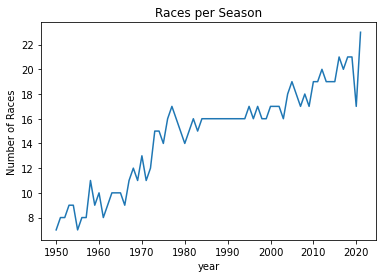

In [4]:
races_per_season = races.groupby('year').count().reset_index()[['year', 'raceId']].rename(columns={'raceId':'Number of Races'})
sns.lineplot(x=races_per_season['year'],y=races_per_season['Number of Races']).set_title("Races per Season")

### Number of Drivers Winning a race per Season
As I have noticed that the number of drivers participating in Races/Seasons, the number of Drivers needs to be considered here as well.

In [5]:
race_years = races[['raceId', 'year']]
df_results = results.merge(race_years, on='raceId', how='left')
df_results_driver_count = df_results.groupby('year').nunique().reset_index()
df_results_driver_count = df_results_driver_count[['driverId','year']]
df_results_driver_count = df_results_driver_count.rename(columns={'driverId': '#ofDrivers'})
race_winners = df_results[df_results['positionOrder'] == 1]
race_winners = race_winners.groupby(['year']).nunique().reset_index()
race_winners = race_winners[['driverId','year']]
race_winners = race_winners.rename(columns={'driverId':'#ofWinners'})
race_winners = race_winners.merge(df_results_driver_count, on='year', how='left')
race_winners = race_winners[['year', '#ofWinners', '#ofDrivers']]
race_winners['relative_num_winners'] = race_winners['#ofWinners'] / race_winners['#ofDrivers']
race_winners.head().style.format({'relative_num_winners': "{:.2f}"})

,year,#ofWinners,#ofDrivers,relative_num_winners
0,1950,3,81,0.04
1,1951,6,84,0.07
2,1952,3,105,0.03
3,1953,5,108,0.05
4,1954,4,97,0.04


Text(0.5, 1.0, 'Number of Drivers over Time')

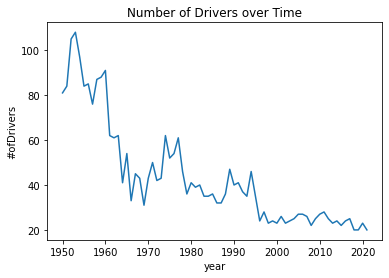

In [6]:
sns.lineplot(x=race_winners['year'],y=race_winners['#ofDrivers']).set_title("Number of Drivers over Time")

We can see that the number of drivers participating in a race has decreased from over 100 in the 50s to just above 20 from mid 90s to today. Looking into the rules there are nowadays 10 teams, with 2 drivers each. the peaks result from drivers missing a race and a replacment driver, taking the seat for this race.

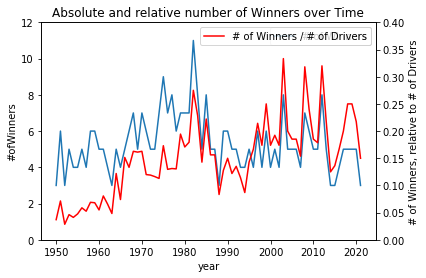

In [7]:
fig = sns.lineplot(x=race_winners['year'],y=race_winners['#ofWinners'])
fig.set(ylim=(0,12))
plt.legend(labels=['# of Winners'])
ax2 = plt.twinx()
sns.lineplot(x=race_winners['year'],y=race_winners['relative_num_winners'], ax=ax2, color="r").set_title("Absolute and relative number of Winners over Time")
ax2.set(ylim=(0,0.4), ylabel='# of Winners, relative to # of Drivers')
plt.legend(labels=['# of Winners / # of Drivers'])

We can see, that there seems to be a slight upwards trend in the relative amount of different drivers, wining a race in a season.

### Development of Pit Stop Times over time

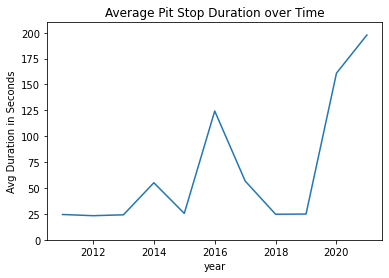

In [8]:
# Average duration
df_pit_stops = pit_stops.merge(race_years, on='raceId', how='left')
df_pit_stops_duration = df_pit_stops.groupby(['year']).mean().reset_index()
df_pit_stops_duration['Avg Duration in Seconds'] = df_pit_stops_duration['milliseconds'] / 1000 
fig = sns.lineplot(x=df_pit_stops_duration['year'], y=df_pit_stops_duration['Avg Duration in Seconds'])
fig = fig.set(ylim=(0,210), title="Average Pit Stop Duration over Time")

We see here some really high peaks, which are hard to explain, especially as we are talking about the average. When looking into the data behind we see, that there is an issue with the formating, that is not the same for every record. This causes the problem and we will take care of this in the Data Pipeline.

### Average number of Stops per Race per Season

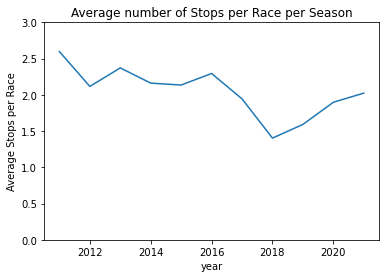

In [9]:
# Aveage number of stops
df_pit_stops_number = df_pit_stops.groupby(['raceId','driverId']).max().reset_index()
df_pit_stops_number = df_pit_stops_number.groupby(['year']).mean().reset_index()
df_pit_stops_number['avg_stops_per_race'] = df_pit_stops_number['stop']
fig = sns.lineplot(x=df_pit_stops_number['year'], y=df_pit_stops_number['avg_stops_per_race'])
fig = fig.set(ylabel='Average Stops per Race', title='Average number of Stops per Race per Season', ylim=(0,3))

We can see that the number of stops has only slightly decreased over the time we have data for, we are therefore not considering this factor further in the further analysis.

### Number of Collisions (Driver could not finish race) per Year

Text(0, 0.5, 'Number of Collisions')

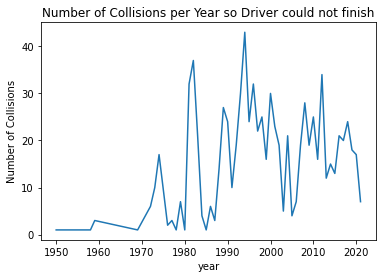

In [10]:
df_results = df_results.merge(status, on="statusId", how='left')
df_results_col = df_results[(df_results['status']=='Collision') | (df_results['status']=='Collision damage')]
df_results_col = df_results_col.groupby(['year']).count().reset_index()
sns.lineplot(x=df_results_col['year'], y=df_results_col['status']).set_title('Number of Collisions per Year so Driver could not finish')
plt.ylabel('Number of Collisions')

Based on this plot it looks like the numbe of collisions increased over time. But taken the number of races per season into account this get relativised, as the number of races increased over time, so there where more chances to crash in a year.

### Average Number of Lappings in a Race per Season

/var/folders/86/jj_j7bm56glckk9r2cy1875h0000gn/T/ipykernel_81463/2551806104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results_lap['Laps behind'] = df_results_lap['status'].str[1:-4].astype(int)


Text(0, 0.5, '')

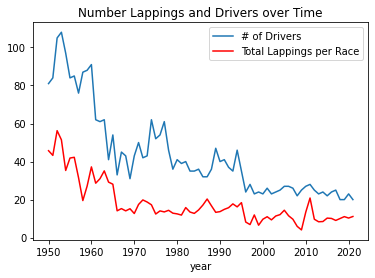

In [11]:
df_results_lap = df_results[df_results['status'].str.startswith('+')]
df_results_lap['Laps behind'] = df_results_lap['status'].str[1:-4].astype(int)
df_lapings_seas = df_results_lap.groupby('raceId').sum().reset_index()[['raceId', 'Laps behind']].rename({'Laps behind':'Avg Laps behind'})
df_results_lap = df_results_lap[['year', 'raceId']].merge(df_lapings_seas, on='raceId', how='left')
df_results_lap = df_results_lap.drop_duplicates()
df_results_lap = df_results_lap.groupby('year').mean().reset_index()
sns.lineplot(x=race_winners['year'],y=race_winners['#ofDrivers'])
sns.lineplot(x=df_results_lap['year'],y=df_results_lap['Laps behind'], color="r").set_title('Number Lappings and Drivers over Time')
plt.legend(labels=['# of Drivers', 'Total Lappings per Race'])
plt.ylabel('')

We can see from the plot that the total number of lappings has decreased over time, which would suggest on the first glance that the field became more homogenous. But taking the parallel decrease in the number of drivers into account, it is reasonable to think that a big part of the decrease can be explained by the decrease in the amount of drivers.

### How did the max speed evolved

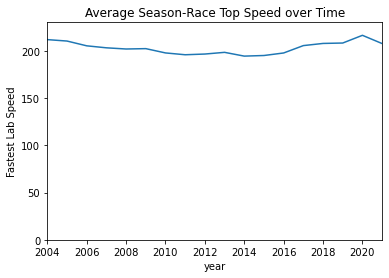

In [12]:
df_results_speed = df_results.groupby('year').mean().reset_index()
fig = sns.lineplot(x=df_results_speed['year'], y=df_results_speed['fastestLapSpeed'])
fig = fig.set(title='Average Season-Race Top Speed over Time', ylabel='Fastest Lab Speed', ylim=(0,230), xlim=(2004,2021))

We can see, that the average top speed has been quite constant over the available time period, with a slight dip between 2010 and 2016.

#### Conclusion of the EDA
After the EDA, I came to the conclusion that there are over a thousand races, of which each might have its own special characteristics making it exciting to watch. However I realized that several datasets only contain data after 2000. Therefore I will focus my analysis on races after 2000.

## Data Analysis Pipeline
As I am planning to conduct analysis on how exciting a race has been, my Pipeline will focus on enriching the race table with new data from the other tables. I am going to collect data in order to include these characteristics:
- How many Overtakes occured in the race
- Was the race close at the top (time difference between 1st and 2nd and average time difference between first 10 drivers)
- Highest speed of the race
- Was this race faster then the previous races on this track (fastest lap compared to track record till date)
- Does the race have a tradition (how many races have been taken place here)
- Is the driver championship exciting?
- Is the constructors championship exciting?
- Average pitstop time

Besides these criteria, I am planning to include the following information to provide the reader with extra information:
- Date of the Race
- Location
- Race Winner + 2nd and 3rd
- Constructors Winner
- Leader of Drivers Championship at this point
- Leader of Constructors Championship at this point
- Pole Position


### 1. Load Data

In [13]:
circuits = pd.read_csv('../data/raw/circuits.csv')
constructor_res = pd.read_csv('../data/raw/constructor_results.csv')
constructor_stand = pd.read_csv('../data/raw/constructor_standings.csv')
constructors = pd.read_csv('../data/raw/constructors.csv')
driver_stand = pd.read_csv('../data/raw/driver_standings.csv')
drivers = pd.read_csv('../data/raw/drivers.csv')
lap_times = pd.read_csv('../data/raw/lap_times.csv')
pit_stops = pd.read_csv('../data/raw/pit_stops.csv')
qualifying = pd.read_csv('../data/raw/qualifying.csv')
races = pd.read_csv('../data/raw/races.csv')
results = pd.read_csv('../data/raw/results.csv')
seasons = pd.read_csv('../data/raw/seasons.csv')
status = pd.read_csv('../data/raw/status.csv')

### 2. Clean Data
Replace the not available data which are marked with \N in the csv files with np.nan to deal with missing values properly

In [14]:
circuits = circuits.replace('\\N',np.nan)
constructor_res = constructor_res.replace('\\N',np.nan)
constructor_stand = constructor_stand.replace('\\N',np.nan)
constructors = constructors.replace('\\N',np.nan)
driver_stand = driver_stand.replace('\\N',np.nan)
drivers = drivers.replace('\\N',np.nan)
lap_times = lap_times.replace('\\N',np.nan)
pit_stops = pit_stops.replace('\\N',np.nan)
qualifying = qualifying.replace('\\N',np.nan)
races = races.replace('\\N',np.nan)
results = results.replace('\\N',np.nan)
seasons = seasons.replace('\\N',np.nan)
status = status.replace('\\N',np.nan)

# Take care of the pitstop time issue we identified in the EDA
pit_stops['duration'] = pit_stops['duration'].apply(lambda x: float(x.split(':')[1]) if ':' in x else float(x))

# Adjust datatype for fastest speed
results['fastestLapSpeed'] = results['fastestLapSpeed'].apply(lambda x: float(x))

# Adjust Time format of fastest lap to be seconds
results['fastestLapTime'] = results['fastestLapTime'].apply(lambda x: float(x.split(':')[0])*60+float(x.split(':')[1]) if type(x)==str else x) 

### 3. Process Data

In [15]:
# Bring races date into date format and drop time only take date till 2020 as the current season is still running
races = races[(races['year']<2021) & (races['year']>1999)]
races['date'] = pd.to_datetime(races['date'], infer_datetime_format=True) 
races = races.drop(columns='time')

# Build drivers name and delete not needed columns
drivers['Driver Name'] = drivers['forename'] + ' ' +  drivers['surname']
drivers = drivers[['driverId', 'Driver Name']]

# Delete not needed columns from the constructors table
constructors = constructors[['constructorId', 'name']].rename(columns={'name': 'Team Name'})

# Delete not needed data from constructors results
constructor_res = constructor_res[['raceId', 'constructorId','points']]

# Delete not needed columns from qualifiying table and select only pole sitters
qualifying = qualifying[qualifying['position']==1][['raceId','driverId']]

# Delete not needed columns form drivers standing
driver_stand = driver_stand[['raceId', 'driverId', 'points', 'position']]

# Delete not needed Data from Constructors Standing
constructor_stand = constructor_stand[['raceId', 'constructorId', 'points', 'position']]

# Delete not needed columns from circuits
circuits = circuits[['circuitId', 'name', 'location']].rename(columns={'name':'Circuit Name', 'location':'City'})

# Delete not needed Data from Pitstop times
pit_stops = pit_stops.drop(columns=['driverId', 'stop', 'lap', 'time', 'milliseconds']).rename(columns={'duration':'avg. Pitstop Duration (in s)'})

### 4. Wrangle Data

In [16]:
# expand results with year and circuitId for further wrangling
results = results.merge(races[['raceId', 'year', 'circuitId']], on='raceId', how='left')

# add Driver Name to results
results = results.merge(drivers, how='left', on='driverId')

# Add Track Information to the races dataframe
races = races.merge(circuits, how='left', on='circuitId')

# add Team Name to results
results = results.merge(constructors, how='left', on='constructorId')

# Add Winner to races (driver and its Team)
races = races.merge(results[['raceId', 'Driver Name', 'Team Name', 'positionOrder']], how='left', on='raceId')
races = races[races['positionOrder']==1].rename(columns={'Driver Name': '1st Driver Name','Team Name': '1st Team Name'}).drop(columns='positionOrder')

# Add 2nd Place to races (driver and its Team)
races = races.merge(results[['raceId', 'Driver Name', 'Team Name', 'positionOrder']], how='left', on='raceId')
races = races[races['positionOrder']==2].rename(columns={'Driver Name': '2nd Driver Name','Team Name': '2nd Team Name'}).drop(columns='positionOrder')

# Add 3rd Place to races (driver and its Team)
races = races.merge(results[['raceId', 'Driver Name', 'Team Name', 'positionOrder']], how='left', on='raceId')
races = races[races['positionOrder']==3].rename(columns={'Driver Name': '3rd Driver Name','Team Name': '3rd Team Name'}).drop(columns='positionOrder')

# Add Constructors Name to constructor results and the the races Winner to Races
constructor_res = constructor_res.merge(constructors, how='left', on='constructorId')
constructors_winners = constructor_res.groupby(['raceId']).max().reset_index()[['raceId', 'points']]
constructors_winners = constructors_winners.merge(constructor_res, how='left', on=['raceId', 'points'])[['raceId', 'Team Name']].rename(columns={'Team Name': 'Constructors Winner'})
races = races.merge(constructors_winners, how='left', on='raceId')

# Add name to qualifying table and merge pole sitter into races
qualifying = qualifying.merge(drivers, how='left', on='driverId').drop(columns='driverId').rename(columns={'Driver Name': 'Pole Sitter'})
races = races.merge(qualifying, how='left', on='raceId')

# Add driver names to driver standing and merge current leader to races (leader after race)
driver_stand = driver_stand.merge(drivers, how='left', on='driverId').drop(columns='driverId')
races = races.merge(driver_stand[driver_stand['position']==1][['raceId', 'Driver Name']], how='left', on='raceId').rename(columns={'Driver Name':'Championship Leader (after Race)'})

# Add Team names to Constructors Championship and merge leader to races
constructor_stand = constructor_stand.merge(constructors, how='left', on='constructorId')
races = races.merge(constructor_stand[constructor_stand['position']==1][['raceId', 'Team Name']], how='left', on='raceId').rename(columns={'Team Name':'Constructors Leader (after Race)'})

# Add leaders (constructors and drivers) before the race (Sort all the races by date and get the leader after the previous race, add prev race Id column to do so)
prevLeaders = races[['year', 'round', 'Championship Leader (after Race)', 'Constructors Leader (after Race)']].rename(columns={'Championship Leader (after Race)':'Championship Leader (before Race)', 'Constructors Leader (after Race)':'Constructors Leader (before Race)'})
races['prev_round'] = races['round']-1
races = races.merge(prevLeaders, how='left', left_on=['year', 'prev_round'], right_on=['year', 'round']).rename(columns={'round_x':'round'})

# Find average pit stop duration and it to races
pit_stops = pit_stops.groupby(['raceId']).mean().reset_index()
races = races.merge(pit_stops, how='left', on='raceId')

# Find difference between first and second and merge into races
diff_1_2 = results[results['positionOrder']==2][['raceId', 'time']].rename(columns={'time':'Difference 1st to 2nd (in s)'})
races = races.merge(diff_1_2[['raceId', 'Difference 1st to 2nd (in s)']], how='left', on='raceId')
races['Difference 1st to 2nd (in s)'] = races['Difference 1st to 2nd (in s)'].apply(lambda x: x.strip(' sec') if type(x)==str else x)
races['Difference 1st to 2nd (in s)'] = races['Difference 1st to 2nd (in s)'].apply(lambda x: float(x[1:].split(':')[0])*60+float(x[1:].strip('s').split(':')[1]) if (type(x)==str and ':'in x) else(float(x[1:].strip('s').split(':')[0]) if type(x)==str else x))

# Find difference avg time difference between first 5 drivers and merge into races
diff_1_5 = results[results['positionOrder']==5][['raceId', 'time']].rename(columns={'time':'avg. Difference Top 5 (in s)'})
races = races.merge(diff_1_5[['raceId', 'avg. Difference Top 5 (in s)']], how='left', on='raceId')
races['avg. Difference Top 5 (in s)'] = races['avg. Difference Top 5 (in s)'].apply(lambda x: float(x[1:].split(':')[0])*60+float(x[1:].strip('s').split(':')[1]) if (type(x)==str and ':'in x) else(float(x[1:].strip('s').split(':')[0]) if type(x)==str else x))
races['avg. Difference Top 5 (in s)'] = races['avg. Difference Top 5 (in s)'] / 4

# Find the races highspeed and merge it into races
highspeeds = results[['raceId', 'fastestLapSpeed']].groupby(['raceId']).max().reset_index()
races = races.merge(highspeeds, how='left', on='raceId').rename(columns={'fastestLapSpeed':'Top Speed of the Race'})


def count_overtakes(raceId, df):
    '''Function to count the number of overtakes in a race, given the raceid and the laptime dataframe'''
    records = df[df['raceId']==raceId][['driverId', 'lap', 'position']]
    records_lat = records.rename(columns={'position':'position_after_round'})
    records_lat['lap'] = records_lat['lap'] + 1
    records = records.merge(records_lat, how='left',on=['driverId','lap'])
    records['overtakes'] = records['position'] - records['position_after_round']     
    records['overtakes'] = records['overtakes'].apply(lambda x: -x if x<0 else 0)
    return records['overtakes'].sum()

# Calculate the number of overtakes and include it into races
races['approx. Number of Overtakes'] = races['raceId'].apply(lambda x: count_overtakes(x, lap_times))

def count_prev_races(data, df):
    '''Count the number races that have been taken place on the race before this one'''
    year = int(data.split(',')[0])
    circuitId = int(data.split(',')[1])
    return len(df[(df['year']<year)&(df['circuitId']==circuitId)])

# Include how often formula 1 raced on this track before
races['Number of prev. F1 Races'] = races['year'].astype(str) + ',' + races['circuitId'].astype(str)
races['Number of prev. F1 Races'] = races['Number of prev. F1 Races'].apply(lambda x: count_prev_races(x,races))

# Include fastest Lap Time
fastest_lap = results[['raceId', 'fastestLapTime']].groupby(['raceId']).min().reset_index()
races = races.merge(fastest_lap, how='left', on='raceId').rename(columns={'fastestLapTime': 'Fastest Lap of the Race'}).drop(columns=['round', 'prev_round'])

def lap_record_to_date(data, df):
    '''find the lap record at the moment the race took place'''
    year = int(data.split(',')[0])
    circuitId = int(data.split(',')[1])
    df = df[(df['year']<year)&(df['circuitId']==circuitId)]
    return df['fastestLapTime'].min()

# Include Lap record to date
races['Lap record to Date'] = races['year'].astype(str) + ',' + races['circuitId'].astype(str)
races['Lap record to Date'] = races['Lap record to Date'].apply(lambda x: lap_record_to_date(x,results))

# Include the difference in the driver championship between first and second
driver_stand_leader = driver_stand[driver_stand['position']==1][['raceId', 'points']].rename(columns={'points':'points1'})
driver_stand_second = driver_stand[driver_stand['position']==2][['raceId', 'points']].rename(columns={'points':'points2'})
driver_stand_difference = driver_stand_leader.merge(driver_stand_second, how='left', on='raceId')
driver_stand_difference['Driver Championship Point Difference'] = driver_stand_difference['points1']-driver_stand_difference['points2']
races = races.merge(driver_stand_difference[['raceId', 'Driver Championship Point Difference']], how='left', on='raceId')

# Include the difference in the constructors championship between first and second
const_stand_leader = constructor_stand[constructor_stand['position']==1][['raceId', 'points']].rename(columns={'points':'points1'})
const_stand_second = constructor_stand[constructor_stand['position']==2][['raceId', 'points']].rename(columns={'points':'points2'})
const_stand_difference = const_stand_leader.merge(const_stand_second, how='left', on='raceId')
const_stand_difference['Constructors Championship Point Difference'] = const_stand_difference['points1']-const_stand_difference['points2']
races = races.merge(const_stand_difference[['raceId', 'Constructors Championship Point Difference']], how='left', on='raceId').drop_duplicates(subset=['year', 'raceId'])

# Save races into processed date folder
races.to_csv('../data/processed/Niklas_Processed/races.csv')

## Method Chaining and writing Python programs

### 1. Build the Chains
I deleted it from here for readability, as code is the same as in python function. If you want to check please see the commit "Chaining Step 1 complete"

### 2. Place the Chains in a function
I deleted it from here for readability, as code is the same as in python function. If you want to check please see the commit "Chaining Step 2 complete"

### 3. Put Chainfunction into python file

In [17]:
from analysis2_pipeline import load_and_process
df_races = load_and_process('../data/raw/')
df_races.head()

/Users/niklastecklenburg/Desktop/DATA_301/group16-project/notebooks/analysis2_pipeline.py:67: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  pd.read_csv(path_to_files + constructor_res_filename)


,raceId,year,round,circuitId,name,date,url,Circuit Name,City,1st Driver Name,...,avg. Difference Top 5 (in s),Top Speed of the Race,Overtakes,Fastest Lap of the Race,Driver Championship Point Difference,Constructors Championship Point Difference,Lap record to Date,Number of prev. F1 Races,Championship Leader (before Race),Constructors Leader (before Race)
0,1,2009,1,1,Australian Grand Prix,2009-03-29,http://en.wikipedia.org/wiki/2009_Australian_G...,Albert Park Grand Prix Circuit,Melbourne,Jenson Button,...,1.21975,217.668,240.0,87.706,2.0,7.0,84.125,13,NaN,NaN
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,Sepang International Circuit,Kuala Lumpur,Jenson Button,...,11.84000,206.483,148.0,96.641,5.0,8.5,94.223,10,Jenson Button,Brawn
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,Shanghai International Circuit,Shanghai,Sebastian Vettel,...,16.27550,174.289,261.0,112.592,6.0,16.5,92.238,5,Jenson Button,Brawn
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,Bahrain International Circuit,Sakhir,Jenson Button,...,9.44475,206.049,179.0,94.556,12.0,22.5,90.252,6,Jenson Button,Brawn
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,Circuit de Barcelona-Catalunya,Montmeló,Jenson Button,...,10.79150,202.484,111.0,82.762,14.0,29.5,75.641,19,Jenson Button,Brawn


## 4. Analysis on my Research Question, Which race has been the most exciting one in the last 70 years.

As a Formula 1 enthusiast, I am watching as many races as I can live. Besides this I also enjoy looking into older races, to see Michael Schumacher or Ayrton Senna racing. When doing so I am having a hard time to decide on which race to watch, as there have been more than 1000 races in the last 70 years. Each of them having there highlights, but there are some that are more interesting/exciting than others. Eventhough it is hard to quantify the excitment of a race, as it highly depends on personal preferences, I am trying to use the Formula 1 Dataset from Kaggle to give an indication, which races to consider.

To quantify how exciting a race has been, I will consider the following statistics:
- How many Overtakes occured in the race
- Was the race close at the top (time difference between 1st and 2nd and average time difference between first 10 drivers)
- Highest speed of the race
- Was this race faster then the previous races on this track (fastest lap compared to track record till date)
- Does the race have a tradition (how many races have been taken place here)
- Is the driver championship exciting?
- Is the constructors championship exciting?
- Average pitstop time

More details on why and how this feature will be implemented will be given in the following, when the analysis is conducted.

### Load the Data

In [18]:
from analysis2_pipeline import load_and_process
df_races = load_and_process('../data/raw/')

sns.set_style('darkgrid')

/Users/niklastecklenburg/Desktop/DATA_301/group16-project/notebooks/analysis2_pipeline.py:67: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  pd.read_csv(path_to_files + constructor_res_filename)


### How many Overtakes occured in the race
Formula 1 is about racing and every fan wants to see as much racing action as possible, when watching a race. Therefore we are using the count of overtakes in the race to quantify the amount of race action. As the Lap times are only recorded for races after 1996, we can only look into these data, as the laptimes are the only way to retrieve the number of overtakes.

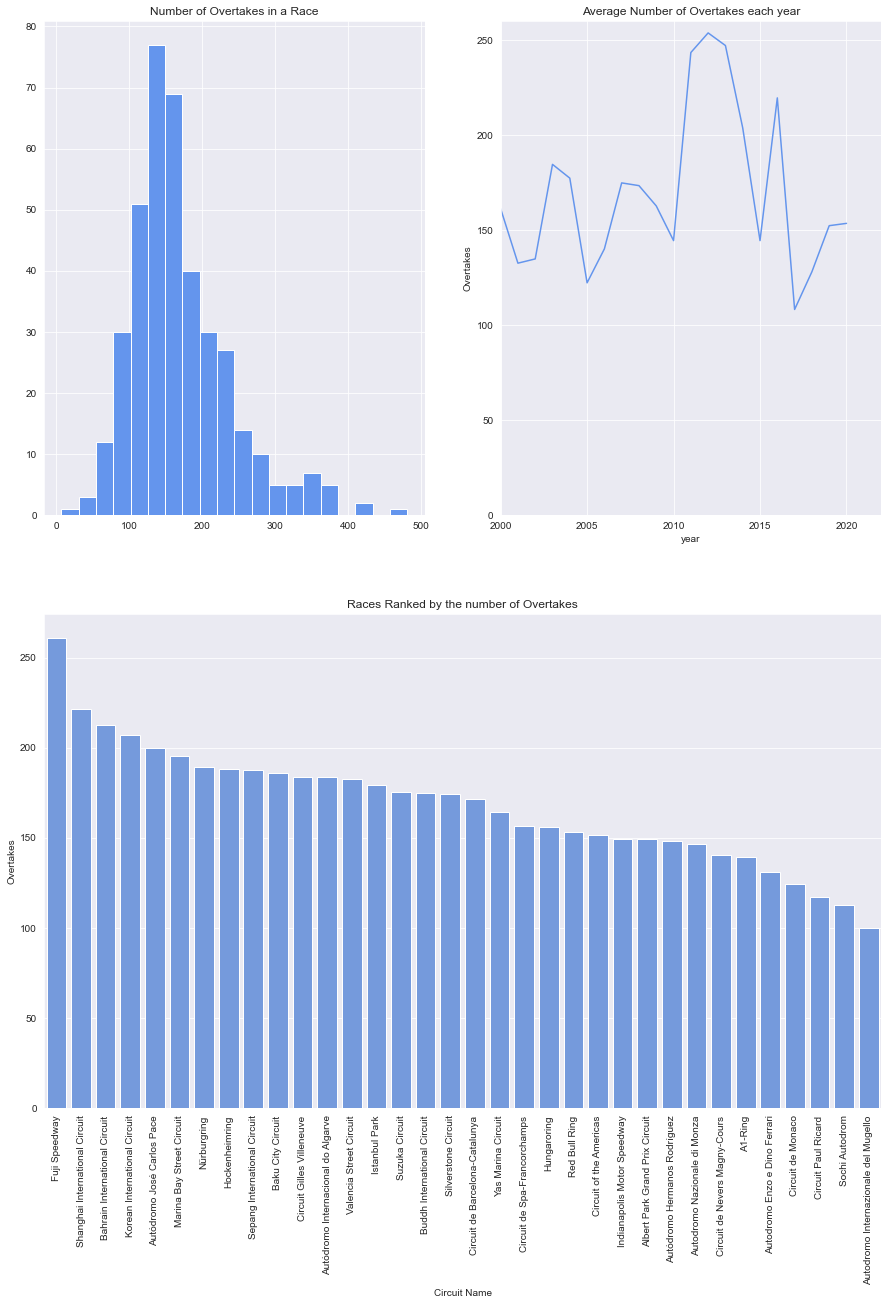

In [19]:
f = plt.figure(figsize=(15, 20))
gs = f.add_gridspec(2,2)

ax = f.add_subplot(gs[0, 0])
# histogram
fig1 = df_races.Overtakes[df_races.Overtakes>0].hist(bins=20,color='cornflowerblue')
fig1.set(title='Number of Overtakes in a Race')

ax = f.add_subplot(gs[0, 1])
# plot average overtakes per season over years
df_overtakes_year = df_races[df_races.Overtakes>0][['year', 'Overtakes']].groupby(['year']).mean().reset_index()
fig2 = sns.lineplot(x=df_overtakes_year.year, y=df_overtakes_year.Overtakes,color='cornflowerblue')
fig2.set(ylim=(0,260), xlim=(2000,2022), xticks=[2000,2005,2010,2015,2020], title='Average Number of Overtakes each year')

ax = f.add_subplot(gs[1, 0:])
# plot average overtakes for each race tracks top 20
df_overtakes_track = df_races[df_races.Overtakes>0][['Circuit Name', 'Overtakes']].groupby(['Circuit Name']).mean().reset_index().sort_values(by=['Overtakes'], ascending=False)
fig3 = sns.barplot(x=df_overtakes_track['Circuit Name'], y=df_overtakes_track['Overtakes'], color='cornflowerblue')
fig3.set(title='Races Ranked by the number of Overtakes')
fig3 = fig3.set_xticklabels(labels=fig3.get_xticklabels(), rotation=90)

In [20]:
df_overtakes_top_ten = df_races[['Circuit Name', 'year', 'Overtakes']].sort_values(by='Overtakes', ascending=False)[:10]
df_overtakes_top_ten['Rank'] = list(range(1,11))
df_overtakes_top_ten = df_overtakes_top_ten[['Rank','Circuit Name', 'year', 'Overtakes']]
df_overtakes_top_ten['Overtakes'] = df_overtakes_top_ten['Overtakes'].astype(int)
print("Races with most Overtakes")
df_overtakes_top_ten.style.hide_index()

Races with most Overtakes


Rank,Circuit Name,year,Overtakes
1,Circuit Gilles Villeneuve,2011,481
2,Shanghai International Circuit,2016,422
3,Autódromo José Carlos Pace,2012,419
4,Sepang International Circuit,2012,384
5,Silverstone Circuit,2013,377
6,Shanghai International Circuit,2012,377
7,Istanbul Park,2011,373
8,Autódromo José Carlos Pace,2014,369
9,Bahrain International Circuit,2012,354
10,Circuit de Barcelona-Catalunya,2012,354


We can see, that there is are on average about 100 overtakes per race. On has to mention here that this result includes a large portion of overtakes, that took place while one car has been in the pitlane. But as this applies to every race, the numbers above are still giving a good estimate on which race had the most overtakes. Regarding the development overtime, we can see that there is a high volatility, with a slight upwards trend from 1996 till 2013 (250 Overtakes in 2012). After 2013 the amount of overtakes dropped below 120 in 2017. Summing up we can say that most overtakes took place in 2015 Season, and most overtakes took place on circuit Gilles Villeneuve in 2011.

### Was there racing for the top positions till the end of the race
Eventhough fighting for positions is always nice to watch, it might become boring, if it is only drivers fighting for becoming 12th. Therefore it is essential for an exciting race, that drivers are battling for top places till the end of the race. Therefore I will take a closer look into the average time difference between the top 5 drivers and especially between the top 2 drivers next.

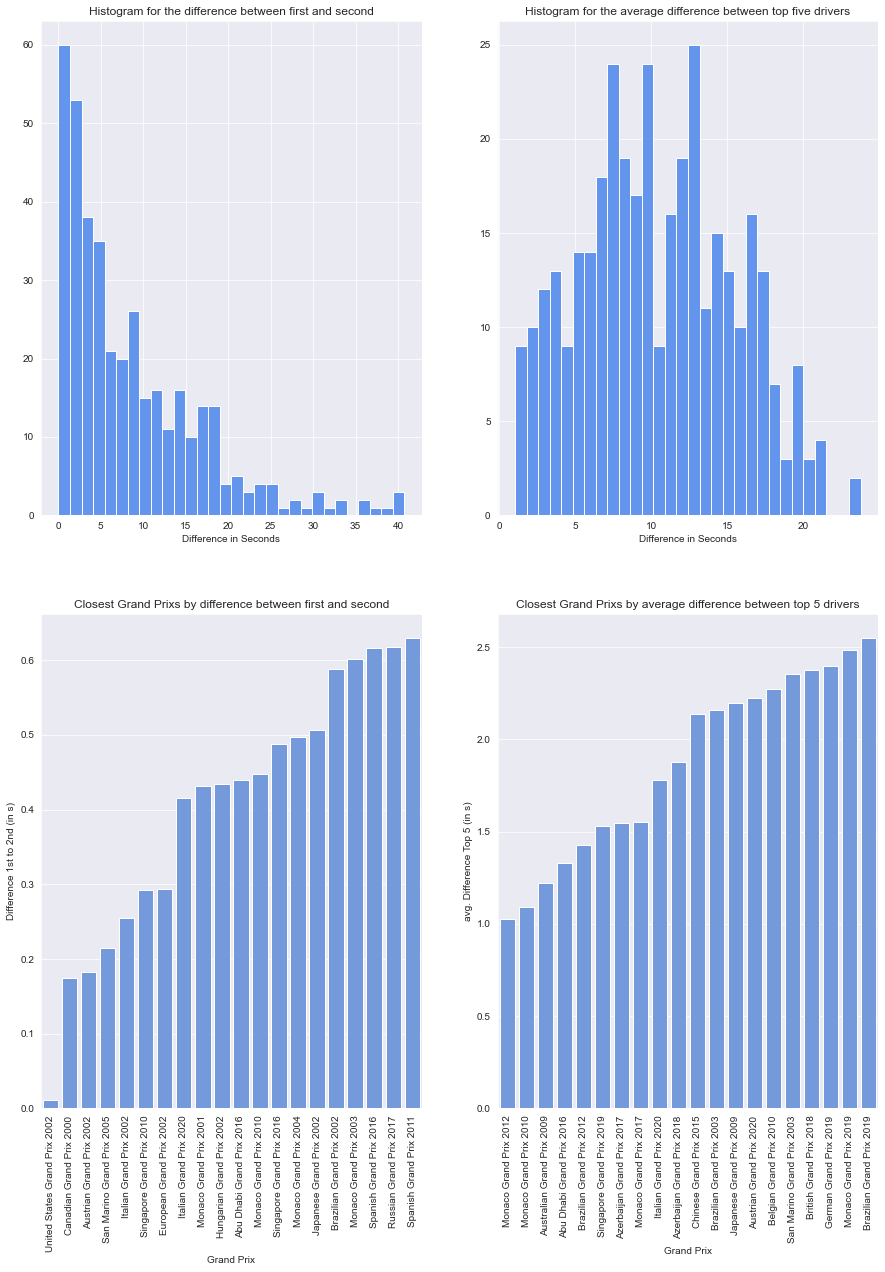

In [21]:
f = plt.figure(figsize=(15, 20))
gs = f.add_gridspec(2,2)

df_time_diff = df_races[['year', 'name', 'Difference 1st to 2nd (in s)', 'avg. Difference Top 5 (in s)']]
#histogram  time difference top 2
ax = f.add_subplot(gs[0, 0])
fig1 = df_time_diff[(df_time_diff['Difference 1st to 2nd (in s)']>0) & (df_time_diff['Difference 1st to 2nd (in s)']<45)]['Difference 1st to 2nd (in s)'].hist(bins=30,color='cornflowerblue')
fig1.set(title='Histogram for the difference between first and second', xlabel='Difference in Seconds')

#histogram  time difference top 5
ax = f.add_subplot(gs[0, 1])
fig2 = df_time_diff[df_time_diff['avg. Difference Top 5 (in s)']>0]['avg. Difference Top 5 (in s)'].hist(bins=30,color='cornflowerblue')
fig2.set(title='Histogram for the average difference between top five drivers', xlabel='Difference in Seconds')

# Top Races by difference of 1st and 2nd
df_top_20 = df_time_diff[df_time_diff['Difference 1st to 2nd (in s)']>0].sort_values(by='Difference 1st to 2nd (in s)')[:20]
df_top_20['Grand Prix'] = df_top_20['name'] + ' ' + df_top_20['year'].astype(str)
ax = f.add_subplot(gs[1, 0])
fig3 = sns.barplot(x=df_top_20['Grand Prix'], y=df_top_20['Difference 1st to 2nd (in s)'], color='cornflowerblue')
fig3.set(title='Closest Grand Prixs by difference between first and second')
fig3 = fig3.set_xticklabels(labels=fig3.get_xticklabels(), rotation=90)

# Top Races by avg. difference of top 5
df_top_20 = df_time_diff[df_time_diff['avg. Difference Top 5 (in s)']>0].sort_values(by='avg. Difference Top 5 (in s)')[:20]
df_top_20['Grand Prix'] = df_top_20['name'] + ' ' + df_top_20['year'].astype(str)
ax = f.add_subplot(gs[1, 1])
fig3 = sns.barplot(x=df_top_20['Grand Prix'], y=df_top_20['avg. Difference Top 5 (in s)'], color='cornflowerblue')
fig3.set(title='Closest Grand Prixs by average difference between top 5 drivers')
fig3 = fig3.set_xticklabels(labels=fig3.get_xticklabels(), rotation=90)

From the plots above we can see especially for the difference between first and second, the plot is heavily right skewed, which is a good thing for every racing fan, as it means we tend to have more races which are close at the top till the end. However we also have some races which were pretty boring at the end as the top drivers where far apart and out of reach to overtake each other.

### What was the Top Speed?
Another aspect every car enthusiast is in to, is speed. Fans not only want to see the cars racing eachother, they also want the race cars to be fast. Therefore we are looking into how the top speed developed overtime in general and for each race track.

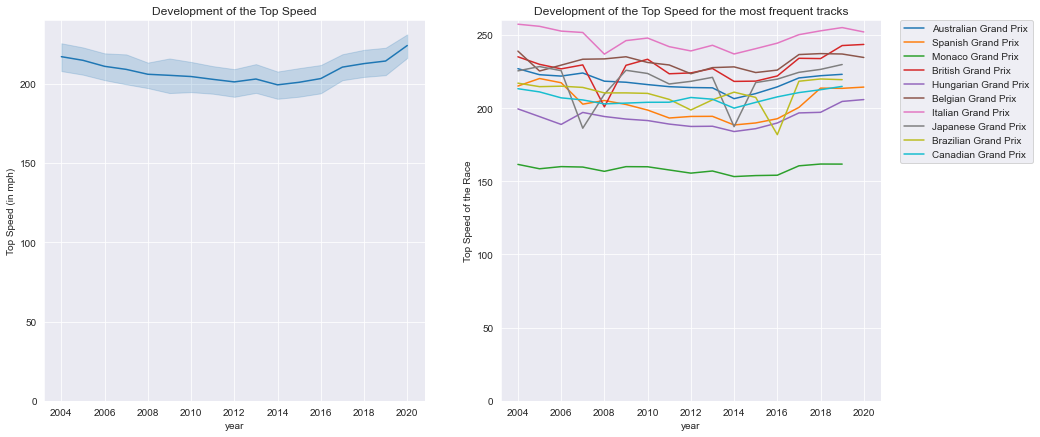

In [22]:
f = plt.figure(figsize=(15, 7))
gs = f.add_gridspec(1,2)

ax = f.add_subplot(gs[0, 0])
df_speed = df_races[['year', 'name', 'Top Speed of the Race']]
fig1 = sns.lineplot(x="year", y="Top Speed of the Race", data=df_speed)
fig1.set(ylim=(0,240), title='Development of the Top Speed', ylabel='Top Speed (in mph)')

ax = f.add_subplot(gs[0,1])
top_ten = df_speed.groupby(['name']).count().sort_values(by='year', ascending=False).reset_index()['name'].to_list()[:10]
fig1 = sns.lineplot(x="year", y="Top Speed of the Race", hue='name', data=df_speed[df_speed['name'].isin(top_ten)])
fig1.set(ylim=(0,260),title='Development of the Top Speed for the most frequent tracks')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [23]:
df_speed_top_ten = df_speed.sort_values(by='Top Speed of the Race', ascending=False)[:10]
df_speed_top_ten['Rank'] = list(range(1,11))
df_speed_top_ten = df_speed_top_ten[['Rank','name', 'year', 'Top Speed of the Race']].rename(columns={'name':'Grand Prix', 'year':'Year'})
print('Races with the highest Speeds')
df_speed_top_ten.style.hide_index().format({'Top Speed of the Race': "{:.2f}"})

Races with the highest Speeds


Rank,Grand Prix,Year,Top Speed of the Race
1,Italian Grand Prix,2004,257.32
2,Italian Grand Prix,2005,255.87
3,Italian Grand Prix,2019,255.01
4,Italian Grand Prix,2018,252.79
5,Italian Grand Prix,2006,252.60
6,Italian Grand Prix,2020,252.03
7,Italian Grand Prix,2007,251.65
8,Italian Grand Prix,2017,250.17
9,Italian Grand Prix,2010,247.86
10,Italian Grand Prix,2009,246.11


We can see that the Italian Grand Prix is the fastest track in the calendar. It is also interesting to see that the most frequent tracks are showing the trend with the lower speeds around 2012, however the drop is not as deep as for the average of all tracks. It is also note worthy that eventhough one might think that the more modern cars are faster than older ones this does not hold true. This is due to two main reasons, the rule changes over the years as well as changing track layouts (also applicable to the Italian grand prix). These changes are made, in order to make the races as secure as possible.

### Was the race faster than previous races on this track
Besides the top speed, also the corner speed as well as the acceleration and deceleration of the cars are attracting the fans attention. As these are hard to quantify based on the available data, I am using the overall laptime, which is the best approximator for the mentioned criteria, that is available. We are going to look here again into the development over time and besides to this we will evealuate the races based on how close the best time got to the track record (record at the time the race took place).

/var/folders/86/jj_j7bm56glckk9r2cy1875h0000gn/T/ipykernel_81463/1555333877.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lap_times['Lap Time relative to Track Record'] = df_lap_times['Fastest Lap of the Race'] / df_lap_times['Lap record to Date']


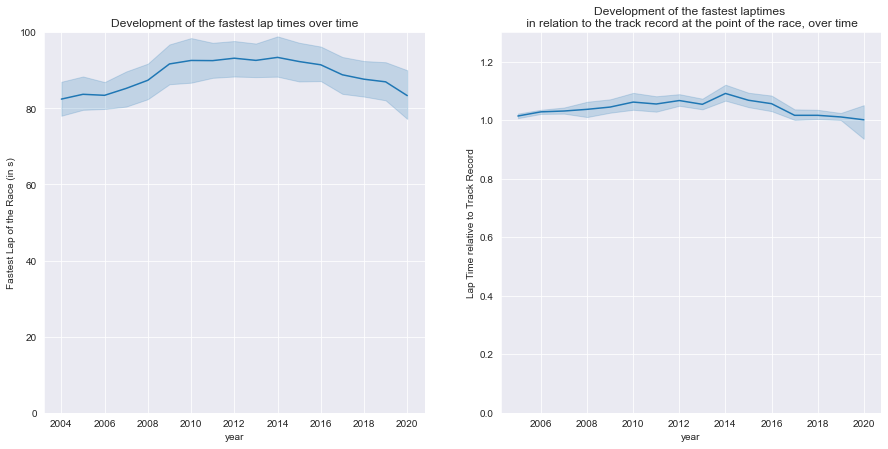

In [24]:
f = plt.figure(figsize=(15, 7))
gs = f.add_gridspec(1,2)

ax = f.add_subplot(gs[0, 0])
df_lap_times = df_races[['year', 'name', 'Fastest Lap of the Race', 'Lap record to Date']]
fig1 = sns.lineplot(x="year", y="Fastest Lap of the Race", data=df_lap_times)
fig1.set(title='Development of the fastest lap times over time', ylim=(0,100), ylabel='Fastest Lap of the Race (in s)')

ax = f.add_subplot(gs[0, 1])
df_lap_times['Lap Time relative to Track Record'] = df_lap_times['Fastest Lap of the Race'] / df_lap_times['Lap record to Date']
fig1 = sns.lineplot(x="year", y="Lap Time relative to Track Record", data=df_lap_times)
fig1 = fig1.set(title='Development of the fastest laptimes \n in relation to the track record at the point of the race, over time', ylim=(0,1.3))

In [25]:
df_time_top_ten = df_lap_times.sort_values(by='Lap Time relative to Track Record', ascending=True)[:10]
df_time_top_ten['Rank'] = list(range(1,11))
df_time_top_ten = df_time_top_ten[['Rank','name', 'year','Fastest Lap of the Race' ,'Lap Time relative to Track Record']].rename(columns={'name':'Grand Prix', 'year':'Year'})
print('Races with the best relation to the track record')
df_time_top_ten.style.hide_index().format({'Fastest Lap of the Race': "{:.2f}", 'Lap Time relative to Track Record': "{:.2f}"})

Races with the best relation to the track record


Rank,Grand Prix,Year,Fastest Lap of the Race,Lap Time relative to Track Record
1,Sakhir Grand Prix,2020,55.40,0.61
2,Japanese Grand Prix,2008,78.43,0.89
3,Korean Grand Prix,2011,99.60,0.90
4,Emilia Romagna Grand Prix,2020,75.48,0.94
5,Austrian Grand Prix,2016,68.41,0.96
6,Singapore Grand Prix,2018,101.91,0.97
7,Azerbaijan Grand Prix,2017,103.44,0.97
8,Hungarian Grand Prix,2019,77.10,0.98
9,Spanish Grand Prix,2005,75.64,0.98
10,Russian Grand Prix,2017,96.84,0.98


Based on the analysis above especially the Sakhir Grand Prix in 2020 set new standards for this track, as the track record could be improved tremendously. But also the Japanese Grand Prix of 2008 looks like it set new standards for this track and it might be worth watching this one. However looking into the plot we can see, that in general track records are not beaten often.

### How much time did the car spend in the pitstop area
Another aspect that catches the attention of the fans are the pitstops, especially the fact that the pit stop crews are able to switch the tires in less than 2 seconds. However besides this, fans want to see the cars racing and not driving slowly through the pit stop area. Therefore we are considering races as exciting for fans if cars spend few time in the pit stop area.

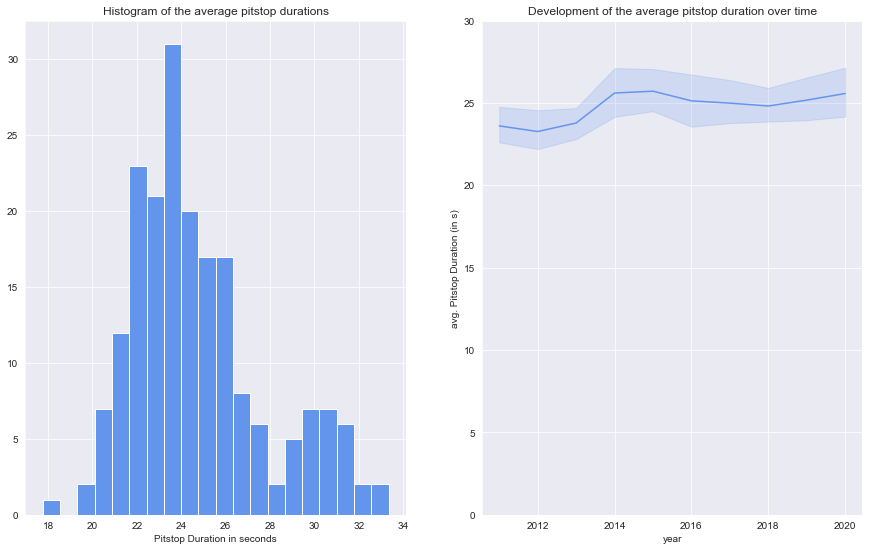

In [26]:
f = plt.figure(figsize=(15, 20))
gs = f.add_gridspec(2,2)

ax = f.add_subplot(gs[0, 0])
# histogram
fig1 = df_races[df_races['avg. Pitstop Duration (in s)']>0]['avg. Pitstop Duration (in s)'].hist(bins=20,color='cornflowerblue')
fig1.set(title='Histogram of the average pitstop durations', xlabel='Pitstop Duration in seconds')

ax = f.add_subplot(gs[0, 1])
df_pitstoptimes = df_races[df_races['avg. Pitstop Duration (in s)']>0][['year', 'name', 'avg. Pitstop Duration (in s)']]
fig2 = sns.lineplot(x=df_pitstoptimes.year, y=df_pitstoptimes['avg. Pitstop Duration (in s)'],color='cornflowerblue')
fig2 = fig2.set(ylim=(0,30), title='Development of the average pitstop duration over time')

In [27]:
df_pit_time_top = df_pitstoptimes.sort_values(by='avg. Pitstop Duration (in s)', ascending=True)[:10]
df_pit_time_top['Rank'] = list(range(1,11))
df_pit_time_top = df_pit_time_top[['Rank','name', 'year','avg. Pitstop Duration (in s)']].rename(columns={'name':'Grand Prix', 'year':'Year'})
print('Races with the fastest pitstops')
df_pit_time_top.style.hide_index().format({'avg. Pitstop Duration (in s)': "{:.2f}"})

Races with the fastest pitstops


Rank,Grand Prix,Year,avg. Pitstop Duration (in s)
1,Australian Grand Prix,2016,17.76
2,German Grand Prix,2012,19.71
3,Hungarian Grand Prix,2012,20.09
4,Brazilian Grand Prix,2017,20.29
5,German Grand Prix,2014,20.39
6,Spanish Grand Prix,2013,20.45
7,Austrian Grand Prix,2016,20.49
8,German Grand Prix,2016,20.50
9,Chinese Grand Prix,2017,20.53
10,Azerbaijan Grand Prix,2019,20.53


### Does the race track have a long tradition
Besides all the performance related factors, Formula 1 racing is a sport with a long history and many traditions. For example the Grand Prix de Monaco is one of the highlights in the Formula 1 Calendar every year, eventhough the races are pretty slow due to the track layout. For the same reason there are only very few opportunities to overtake. In order to include this factor into the analysis we are considering the number of races that already took place at this track before the race.

array([[<AxesSubplot:title={'center':'Number of prev. F1 Races'}>]],
      dtype=object)

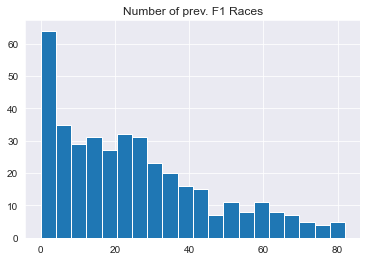

In [28]:
df_tradition = df_races[['name', 'Number of prev. F1 Races']]
df_tradition.hist(bins=20)

In [29]:
df_tradition = df_races[['name', 'Number of prev. F1 Races']]
top_ten = df_tradition.groupby(['name']).max().sort_values(by='Number of prev. F1 Races', ascending=False).reset_index()[:11]
top_ten = top_ten.drop([2]) # Drop 70th aniversary grand prix as this is the same as the british grand prix (problem occured due to construction of this attribute based on circuitId)

top_ten['Rank'] = list(range(1,11))
top_ten = top_ten[['Rank', 'name', 'Number of prev. F1 Races']].rename(columns={'name':'Grand Prix'})
print('Tracks with the most Tradition')
top_ten.style.hide_index().format({'Number of prev. F1 Races': "{:.2f}"})

Tracks with the most Tradition


Rank,Grand Prix,Number of prev. F1 Races
1,Italian Grand Prix,82.00
2,Monaco Grand Prix,71.00
3,British Grand Prix,61.00
4,Belgian Grand Prix,55.00
5,Eifel Grand Prix,44.00
6,German Grand Prix,43.00
7,Canadian Grand Prix,41.00
8,European Grand Prix,39.00
9,Hungarian Grand Prix,37.00
10,Brazilian Grand Prix,36.00


This table shows us, what F1 fans would have already guessed the top four Grand Prixs with the most history are, the Italian one in Monza, the race in Monaco as well as the ones in Silverstone and Spa.

### Does the race have any importance for the Championship (Driver and Constructors)
The final factor we are considering, that adds tension to a race is its importance for the title race. If it is already clear which driver and which team will take home the championship the race is no longer that exciting compared to one where drivers and teams have to fight for every point in the championship. Here we will consider the difference between the leader and the second place in the championships as well as the factor how many races have already been raced, because the later we are in the season the higher the tension.

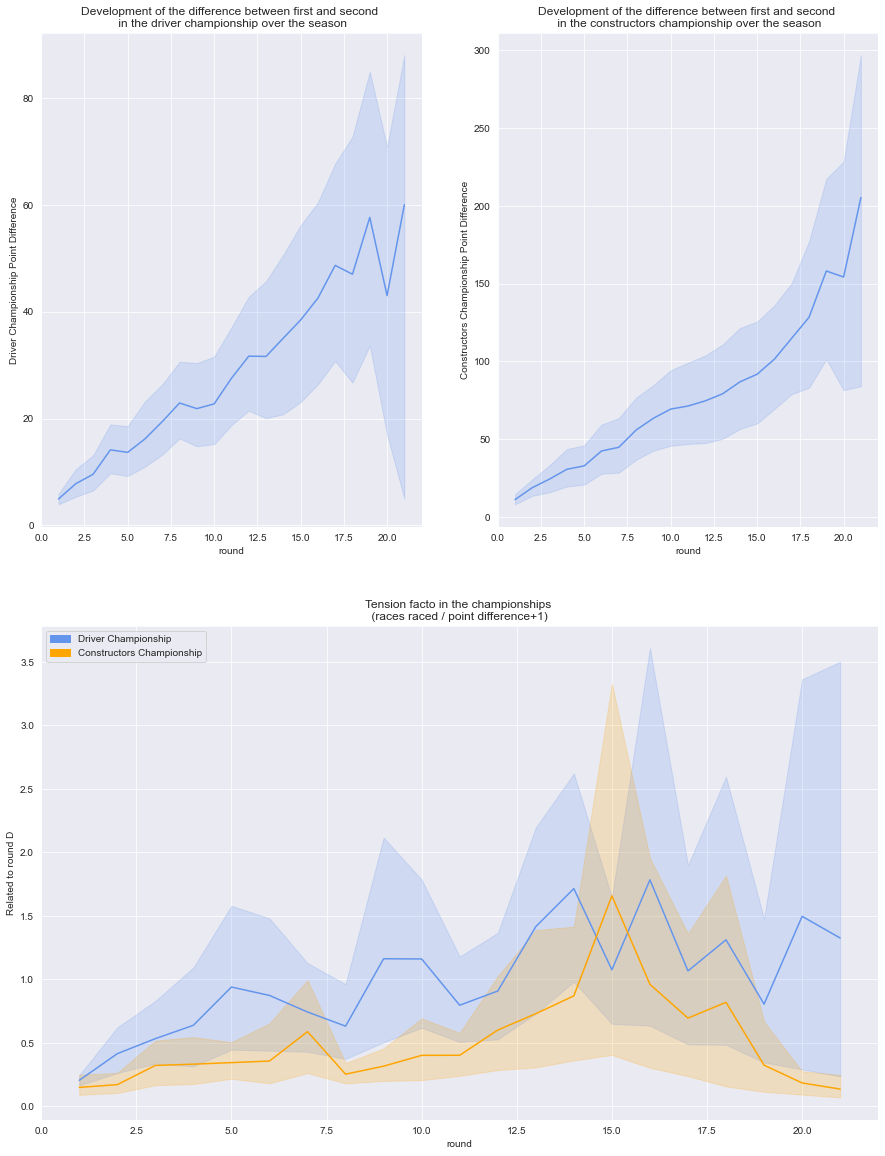

In [30]:
f = plt.figure(figsize=(15, 20))
gs = f.add_gridspec(2,2)

# Point difference over round drivers
ax = f.add_subplot(gs[0, 0])
fig1 = sns.lineplot(x=df_races['round'], y=df_races['Driver Championship Point Difference'],color='cornflowerblue')
fig1.set(title='Development of the difference between first and second \n in the driver championship over the season')

# Point difference over round constructors
ax = f.add_subplot(gs[0, 1])
fig2 = sns.lineplot(x=df_races['round'], y=df_races['Constructors Championship Point Difference'],color='cornflowerblue')
fig2.set(title='Development of the difference between first and second \n in the constructors championship over the season')

# Build score for drivers and championship
ax = f.add_subplot(gs[1, 0:])
df_races['Related to round D'] = df_races['round'] / (1+ df_races['Driver Championship Point Difference'])
fig3 = sns.lineplot(x=df_races['round'], y=df_races['Related to round D'],color='cornflowerblue')

# Build score for constructors and championship
df_races['Related to round C'] = df_races['round'] / (1 + df_races['Constructors Championship Point Difference'])
fig3 = sns.lineplot(x=df_races['round'], y=df_races['Related to round C'],color='orange')
fig3.set(title='Tension facto in the championships \n (races raced / point difference+1) ')
l1 = mpatches.Patch(color='cornflowerblue', label='Driver Championship')
l2 = mpatches.Patch(color='orange', label='Constructors Championship')

fig3.legend(handles=[l1,l2], loc=2)



In [31]:
df_races['Tension Score'] = df_races['Related to round C'] + df_races['Related to round D']
df_top_tension = df_races.sort_values(by='Tension Score', ascending=False)[:10]
df_top_tension['Rank'] = list(range(1,11))
df_top_tension = df_top_tension[['Rank','name', 'year', 'round','Tension Score']].rename(columns={'round':'Race of the Season', 'name':'Grand Prix', 'year':'Year'})
print('Top Races ranked by their relevance for the Championships')
df_top_tension.style.hide_index().format({'Tension Score': "{:.2f}"})

Top Races ranked by their relevance for the Championships


Rank,Grand Prix,Year,Race of the Season,Tension Score
1,Chinese Grand Prix,2006,16,24.00
2,United States Grand Prix,2000,15,16.67
3,Brazilian Grand Prix,2008,18,9.82
4,Belgian Grand Prix,2010,13,9.75
5,British Grand Prix,2008,9,9.60
6,Singapore Grand Prix,2008,15,9.38
7,Italian Grand Prix,2008,14,9.33
8,Italian Grand Prix,2006,15,8.75
9,Brazilian Grand Prix,2007,17,8.66
10,Hungarian Grand Prix,2003,13,7.94


The Tension Score is calculated by summing the two scores for the constructors and the drivers championship. These are received by combining the number of races that have been already raced in a season and difference in the championship between first and second.

We can see from the first plots, that the distants between first and second increases over the season, which makes absolutely sense as the leader is likely to expand its lead. What is interesting is that on average the constructor championship seems to be decided earlier than the driver championship. This can be explained by the fact that every team has two drivers, so there are several season where two drivers from the same team are fighting for the championship. It is interesting that the closer this race is, the clearer is the constructors championship, because these two drivers collect the majority of points for the same team. 

### Coming up with a Ranking, which races are the most exciting to watch
To give a final recommendation, which races in the last 20 years are worth watching the most, we are going to combine the described features, by normalizing them with min-max principle into the range between 0 and 1. Afterwards we will add the Scores and bring them again into the range between 0 and 1. (Note that the Score for the tradition needed to be adjusted, in order to avoid strong dominance of this factor)

In [32]:
def normalize_tradition(year, tradition, df):
    max_this_year = df[df['year']==year]['Number of prev. F1 Races'].max()
    min_this_year = df[df['year']==year]['Number of prev. F1 Races'].min()
    return ((tradition-min_this_year) / (max_this_year-min_this_year))

/var/folders/86/jj_j7bm56glckk9r2cy1875h0000gn/T/ipykernel_81463/2271791407.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_races[df_races['Distance Top 2 (normalized)']>1]['Distance Top 2 (normalized)'] = 0
/var/folders/86/jj_j7bm56glckk9r2cy1875h0000gn/T/ipykernel_81463/2271791407.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_races[df_races['Distance Top 5 (normalized)']>1]['Distance Top 5 (normalized)'] = 0


[Text(0.5, 1.0, 'Historgram of the Overall Score (0 to 100)')]

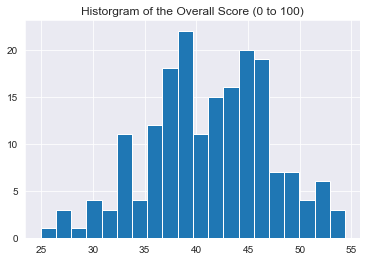

In [44]:
df_races['Overtakes (normalized)'] = (df_races['Overtakes']- df_races['Overtakes'].min()) / (df_races['Overtakes'].max() - df_races['Overtakes'].min())
df_races['Distance Top 2 (normalized)'] = (df_races['Difference 1st to 2nd (in s)'].max() - df_races['Difference 1st to 2nd (in s)']) / (df_races['Difference 1st to 2nd (in s)'].max() - df_races[df_races['Difference 1st to 2nd (in s)']>0]['Difference 1st to 2nd (in s)'].min())
df_races[df_races['Distance Top 2 (normalized)']>1]['Distance Top 2 (normalized)'] = 0
df_races['Distance Top 5 (normalized)'] = (df_races['avg. Difference Top 5 (in s)'].max() - df_races['avg. Difference Top 5 (in s)']) / (df_races['avg. Difference Top 5 (in s)'].max() - df_races[df_races['avg. Difference Top 5 (in s)']>0]['avg. Difference Top 5 (in s)'].min())
df_races[df_races['Distance Top 5 (normalized)']>1]['Distance Top 5 (normalized)'] = 0
df_races['Top Speed (normalized)'] = (df_races['Top Speed of the Race']- df_races['Top Speed of the Race'].min()) / (df_races['Top Speed of the Race'].max() - df_races['Top Speed of the Race'].min())
df_races['Relative Laptime (normalized)'] = df_races['Lap record to Date'] / df_races['Fastest Lap of the Race']
df_races['Relative Laptime (normalized)'] = (df_races['Relative Laptime (normalized)']- df_races['Relative Laptime (normalized)'].min()) / (df_races['Relative Laptime (normalized)'].max() - df_races['Relative Laptime (normalized)'].min())
df_races['Pitstop Time (normalized)'] = (df_races['avg. Pitstop Duration (in s)'].max()-df_races['avg. Pitstop Duration (in s)']) / (df_races['avg. Pitstop Duration (in s)'].max()-df_races['avg. Pitstop Duration (in s)'].min())
df_races = df_races.assign(Tradition_normalized = lambda x: normalize_tradition(x.year, x['Number of prev. F1 Races'], df_races))
df_races['Championship Importance'] = (df_races['Tension Score']- df_races['Tension Score'].min()) / (df_races['Tension Score'].max() - df_races['Tension Score'].min())

df_races['Overall Score'] = (df_races['Overtakes (normalized)'] + df_races['Distance Top 2 (normalized)'] + df_races['Distance Top 5 (normalized)'] + df_races['Top Speed (normalized)'] + df_races['Relative Laptime (normalized)'] + df_races['Pitstop Time (normalized)'] + df_races['Tradition_normalized']/4 + df_races['Championship Importance']) /  8
df_races = df_races.sort_values(by='Overall Score', ascending=False)
fig = df_races['Overall Score'].hist(bins=20)
fig.set(title='Historgram of the Overall Score')

### Final Result which Races to watch

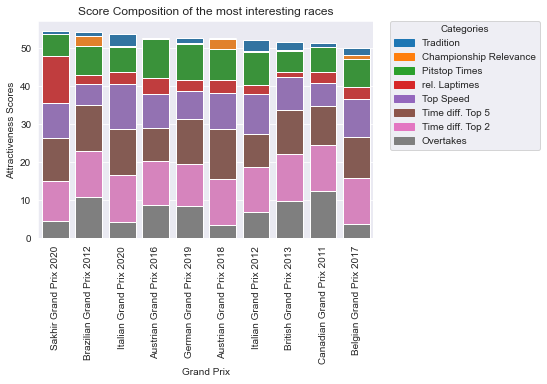

In [45]:
df_races['Grand Prix'] = df_races['name'] + ' ' + df_races['year'].astype(str)
df_races_top = df_races[:10]
colors = sns.color_palette()
fig = sns.barplot(x=df_races_top['Grand Prix'], y=df_races_top['Overall Score (0 to 100)'],color=colors[0])
fig = sns.barplot(x=df_races_top['Grand Prix'], y=(df_races_top['Overtakes (normalized)'] + df_races_top['Distance Top 2 (normalized)'] + df_races_top['Distance Top 5 (normalized)'] + df_races_top['Top Speed (normalized)'] + df_races_top['Relative Laptime (normalized)'] + df_races_top['Pitstop Time (normalized)'] + df_races_top['Championship Importance (normalized)']), color=colors[1])
fig = sns.barplot(x=df_races_top['Grand Prix'], y=(df_races_top['Overtakes (normalized)'] + df_races_top['Distance Top 2 (normalized)'] + df_races_top['Distance Top 5 (normalized)'] + df_races_top['Top Speed (normalized)'] + df_races_top['Relative Laptime (normalized)'] + df_races_top['Pitstop Time (normalized)']), color=colors[2])
fig = sns.barplot(x=df_races_top['Grand Prix'], y=(df_races_top['Overtakes (normalized)'] + df_races_top['Distance Top 2 (normalized)'] + df_races_top['Distance Top 5 (normalized)'] + df_races_top['Top Speed (normalized)'] + df_races_top['Relative Laptime (normalized)'] ), color=colors[3])
fig = sns.barplot(x=df_races_top['Grand Prix'], y=(df_races_top['Overtakes (normalized)'] + df_races_top['Distance Top 2 (normalized)'] + df_races_top['Distance Top 5 (normalized)'] + df_races_top['Top Speed (normalized)'] ), color=colors[4])
fig = sns.barplot(x=df_races_top['Grand Prix'], y=(df_races_top['Overtakes (normalized)'] + df_races_top['Distance Top 2 (normalized)'] + df_races_top['Distance Top 5 (normalized)'] ), color=colors[5])
fig = sns.barplot(x=df_races_top['Grand Prix'], y=(df_races_top['Overtakes (normalized)'] + df_races_top['Distance Top 2 (normalized)'] ), color=colors[6])
fig = sns.barplot(x=df_races_top['Grand Prix'], y=(df_races_top['Overtakes (normalized)'] ), color=colors[7])
fig.set(ylabel='Attractiveness Scores')

l1 = mpatches.Patch(color=colors[0], label='Tradition')
l2 = mpatches.Patch(color=colors[1], label='Championship Relevance')
l3 = mpatches.Patch(color=colors[2], label='Pitstop Times')
l4 = mpatches.Patch(color=colors[3], label='rel. Laptimes')
l5 = mpatches.Patch(color=colors[4], label='Top Speed')
l6 = mpatches.Patch(color=colors[5], label='Time diff. Top 5')
l7 = mpatches.Patch(color=colors[6], label='Time diff. Top 2')
l8 = mpatches.Patch(color=colors[7], label='Overtakes')

fig.legend(handles=[l1,l2,l3,l4,l5,l6,l7,l8], title='Categories',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.set(title='Score Composition of the most interesting races')
fig = fig.set_xticklabels(labels=fig.get_xticklabels(), rotation=90)

The Grand Prixs shown in the Barplot above are the final recommendations I would give you to watch, based on the analysis I have just walked you through. It is interesting to see that the recommended Races are similiar in some categories, like the time differences at the top of the field, but also differ in other categories. For example if you want to see High Speeds you should go for on of the three Italian Grand Prixs recommended. If you want to see new track records being set you should take a look the Sakhir Grand Prix and  if you are in to overtakes the Canadian Grand Prix would be the right choice. Further analysis and comparison, eg. if you have a favorite race track could be run aesily using the df_races dataframe. 

### Comprehension of the top 3 races

In [46]:
df_races_top_3 = df_races[['Grand Prix', 'Circuit Name', 'City', 'date', '1st Driver Name', '2nd Driver Name', '3rd Driver Name', 'Constructors Winner', 'Pole Sitter', 'Championship Leader (before Race)', 'Championship Leader (after Race)','Constructors Leader (before Race)', 'Constructors Leader (after Race)','Top Speed of the Race','Overtakes','Fastest Lap of the Race','Driver Championship Point Difference','Constructors Championship Point Difference','Lap record to Date','Number of prev. F1 Races']][:3]
df_races_top_3 = df_races_top_3.rename(columns={'date': 'Date', '1st Driver Name':'Winner','2nd Driver Name':'2nd', '3rd Driver Name':'3rd' })
df_races_top_3 = df_races_top_3.set_index('Grand Prix')
df_races_top_3 = df_races_top_3.transpose()
print("Comprehension of the 3 most Interesting Races")
df_races_top_3

Comprehension of the 3 most Interesting Races


Grand Prix,Sakhir Grand Prix 2020,Brazilian Grand Prix 2012,Italian Grand Prix 2020
Circuit Name,Bahrain International Circuit,Autódromo José Carlos Pace,Autodromo Nazionale di Monza
City,Sakhir,São Paulo,Monza
Date,2020-12-06 00:00:00,2012-11-25 00:00:00,2020-09-06 00:00:00
Winner,Sergio Pérez,Jenson Button,Pierre Gasly
2nd,Esteban Ocon,Fernando Alonso,Carlos Sainz
3rd,Lance Stroll,Felipe Massa,Lance Stroll
Constructors Winner,Racing Point,Ferrari,McLaren
Pole Sitter,Valtteri Bottas,Lewis Hamilton,Lewis Hamilton
Championship Leader (before Race),Lewis Hamilton,Sebastian Vettel,Lewis Hamilton
Championship Leader (after Race),Lewis Hamilton,Sebastian Vettel,Lewis Hamilton


In [47]:
# Save df with analysis
df_races.to_csv('../data/processed/Niklas_Processed/data_ananlysis.csv')

In [49]:
df_races.head(10)

,raceId,year,round,circuitId,name,date,url,Circuit Name,City,1st Driver Name,...,Distance Top 5 (normalized),Top Speed (normalized),Relative Laptime (normalized),Pitstop Time (normalized),Tradition_normalized,Tradition (normalized),Championship Importance (normalized),Overall Score (0 to 100),Grand Prix,Rank
421,1046,2020,16,3,Sakhir Grand Prix,2020-12-06,https://en.wikipedia.org/wiki/2020_Sakhir_Gran...,Bahrain International Circuit,Sakhir,Sergio Pérez,...,11.232949,9.245447,12.500000,5.722710,0.048780,0.609756,0.026264,54.378387,Sakhir Grand Prix 2020,1
263,879,2012,20,18,Brazilian Grand Prix,2012-11-25,http://en.wikipedia.org/wiki/2012_Brazilian_Gr...,Autódromo José Carlos Pace,São Paulo,Jenson Button,...,12.279375,5.461756,2.201516,7.672514,0.088415,1.105183,2.719248,54.304505,Brazilian Grand Prix 2012,2
413,1038,2020,8,14,Italian Grand Prix,2020-09-06,https://en.wikipedia.org/wiki/2020_Italian_Gra...,Autodromo Nazionale di Monza,Monza,Pierre Gasly,...,12.087168,11.865202,3.124516,6.657034,0.250000,3.125000,0.049525,53.554203,Italian Grand Prix 2020,3
331,956,2016,9,70,Austrian Grand Prix,2016-07-03,https://en.wikipedia.org/wiki/2016_Austrian_Gr...,Red Bull Ring,Spielburg,Lewis Hamilton,...,8.809639,8.937233,4.016917,10.307540,0.006098,0.076220,0.366619,52.755211,Austrian Grand Prix 2016,4
395,1020,2019,11,10,German Grand Prix,2019-07-28,https://en.wikipedia.org/wiki/2019_German_Gran...,Hockenheimring,Hockenheim,Max Verstappen,...,11.747375,7.399407,2.881508,9.527735,0.115854,1.448171,0.104288,52.659715,German Grand Prix 2019,5
372,997,2018,9,70,Austrian Grand Prix,2018-07-01,https://en.wikipedia.org/wiki/2018_Austrian_Gr...,Red Bull Ring,Spielburg,Max Verstappen,...,13.063027,9.479099,3.518939,7.937615,0.012195,0.152439,2.714174,52.521380,Austrian Grand Prix 2018,6
256,872,2012,13,14,Italian Grand Prix,2012-09-09,http://en.wikipedia.org/wiki/2012_Italian_Gran...,Autodromo Nazionale di Monza,Monza,Lewis Hamilton,...,8.823368,10.306725,2.396387,8.604039,0.225610,2.820122,0.334614,52.007903,Italian Grand Prix 2012,7
271,887,2013,8,9,British Grand Prix,2013-06-30,http://en.wikipedia.org/wiki/2013_British_Gran...,Silverstone Circuit,Silverstone,Nico Rosberg,...,11.517551,8.866634,1.155172,5.653656,0.161585,2.019817,0.204427,51.537182,British Grand Prix 2013,8
229,847,2011,7,7,Canadian Grand Prix,2011-06-12,http://en.wikipedia.org/wiki/2011_Canadian_Gra...,Circuit Gilles Villeneuve,Montreal,Jenson Button,...,10.262993,6.098835,2.795720,6.479614,0.100610,1.257622,0.040919,51.443841,Canadian Grand Prix 2011,9
355,980,2017,12,13,Belgian Grand Prix,2017-08-27,https://en.wikipedia.org/wiki/2017_Belgian_Gra...,Circuit de Spa-Francorchamps,Spa,Lewis Hamilton,...,10.803779,10.010158,3.222112,7.413142,0.158537,1.981707,0.853835,50.075215,Belgian Grand Prix 2017,10
